# Imports

In [106]:
# general
import pandas as pd
import numpy as np
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

# to ingore pandas warnings
import warnings

# preprocessing
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler

# import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

# metrics
from sklearn.metrics import accuracy_score

# optimizer
from sklearn.model_selection import GridSearchCV

# k-fold cross-validation
from sklearn.model_selection import cross_val_score

# chi-squared
from scipy.stats import chi2_contingency

# ANOVA
import statsmodels.api as sm

<b> Functions for training and evaluating models </b>

# Initial Data

Load data

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
full_df = pd.read_csv("titanic.csv")

Ignore pandas warnings

In [3]:
warnings.filterwarnings('ignore')

Set column names to lower case

In [4]:
test_df.columns = [column.lower() for column in test_df.columns]
train_df.columns = [column.lower() for column in train_df.columns]

Remove quotation marks from names

In [5]:
for i, name in enumerate(train_df["name"]):
    if '"' in name:
        train_df["name"][i] = re.sub('"', '', name)

for i, name in enumerate(test_df["name"]):
    if '"' in name:
        test_df["name"][i] = re.sub('"', '', name)

for i, name in enumerate(full_df["name"]):
    if '"' in name:
        full_df["name"][i] = re.sub('"', '', name)

The features; `passangerid` and `ticket` are useless, while `cabin` is missing for most instances. We'll remove them.

In [6]:
full_df = full_df.drop(columns=["boat", "body", "home.dest", 'ticket', 'cabin'])
train_df = train_df.drop(columns=['cabin', 'passengerid', 'ticket'])

Add `survived` to the test data from the full dataset, then change the order of columns to match the training set.

In [7]:
test_with_labels = pd.merge(test_df, full_df, how='left')
test_df = test_with_labels[list(train_df.columns)]

Get the target labels.

In [8]:
y_train = train_df['survived']
y_test = test_df['survived']

In [9]:
full_df = [train_df, test_df]

# Features

## 1. `sex` and `pclass`

`sex` and `pclass` are obvious predictors. There's a clear pattern in the survival rate across the factor levels.

In [10]:
train_df[['sex', 'survived']].groupby(['sex']).mean()

,survived
sex,
female,0.742038
male,0.188908


In [11]:
train_df[['pclass', 'survived']].groupby(['pclass']).mean()

,survived
pclass,
1,0.629630
2,0.472826
3,0.242363


## 2. `name`

From the `name` feature we extract the titles.

In [151]:
train_df['title'] = train_df['name'].str.extract(r'([A-Za-z]+\.)')
test_df['title'] = test_df['name'].str.extract(r'([A-Za-z]+\.)')
pd.crosstab(train_df['title'], train_df['sex'])

sex,female,male
title,,
Capt.,0,1
Col.,0,2
Countess.,1,0
Don.,0,1
Dr.,1,6
Jonkheer.,0,1
Lady.,1,0
Major.,0,2
Master.,0,40


Majority of the titles belong to 'Master.', 'Miss.', 'Mrs.', and 'Mr.'. We clean up the rest into either of these, or into 'Rare' next.

In [152]:
for frame in full_df:
    frame['title'] = frame['title'].replace(['Capt.', 'Col.', 'Countess.', 'Don.', 'Dr.', 'Jonkheer.', 'Lady.', 'Major.', 'Rev.', 'Sir.', 'Dona.' ],
                                             'Rare')
    frame['title'] = frame['title'].replace(['Mlle.', 'Ms.'], 'Miss.')
    frame['title'] = frame['title'].replace('Mme.', 'Mrs.')

In [153]:
train_df[['title', 'survived']].groupby(['title']).mean()

,survived
title,
Master.,0.575000
Miss.,0.702703
Mr.,0.156673
Mrs.,0.793651
Rare,0.347826


## 3. `age`

Fill `age` with values from the fitted normal distribution.

Fit a normal distribution to the `age` column, then draw a sample from that distribution and fill the missing values using the sample. 

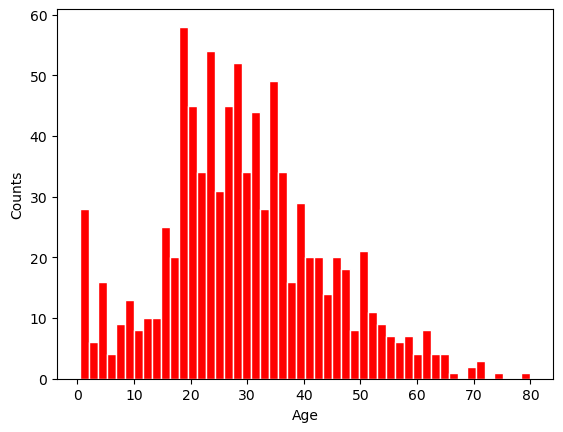

In [15]:
# fit normal distribution to age
age_nona = train_df[train_df['age'].isna() == False]['age']
fit_params = norm.fit(age_nona)
mean, std_dev = fit_params

# get avlues
random_sample = norm.rvs(mean, std_dev, size=200, random_state=42)
# limit values to be > 0
positive_random_sample = random_sample[random_sample > 0]

# fill values to datasets
for frame in full_df:
    # obtain the indices of the missing values
    missing_indices = frame.index[frame['age'].isnull()]
    
    # fill the instances with the random sample
    frame.loc[missing_indices, 'age'] = positive_random_sample[:len(missing_indices)]

#plot
plt.hist(train_df['age'], bins=50, edgecolor='white', color='red');
plt.ylabel('Counts');
plt.xlabel('Age');

The distribution looks unchanged, this looks good.

We also normalize `age`.

In [16]:
scaler = MinMaxScaler()
for frame in full_df:
    frame['age_scaled'] = scaler.fit_transform(frame[['age']])

## 4. `fare`

Fill the missing value in the test set then normalize `fare` too.

In [17]:
test_df['fare'].fillna(train_df['fare'].median(), inplace=True)

In [18]:
for frame in full_df:
    frame['fare_scaled'] = scaler.fit_transform(frame[['fare']])

## 5. `sibsp` and `parch`

The features `sibsp` and `parch` are very similar and difficult to comprehend. Combine.

In [135]:
for frame in full_df:
    frame['alone'] = (frame['sibsp'] == 0) & (frame['parch'] == 0)
train_df[['alone', 'survived']].groupby(['alone']).mean()

,survived
alone,
False,0.505650
True,0.303538


## 6. 'embarked'

Missing some values, so fill in `embarked` with the most popular value 

In [20]:
train_df['embarked'].fillna(train_df['embarked'].mode()[0], inplace=True)
train_df[['embarked', 'survived']].groupby(['embarked']).mean()

,survived
embarked,
C,0.553571
Q,0.389610
S,0.339009


# Initial Model Training & Evaluation

Select promising featurs.

In [121]:
features = ['pclass', 'sex', 'sibsp', 'parch', 'embarked', 'title', 'age_scaled', 'fare_scaled', 'alone']
X_train = pd.get_dummies(train_df[features])
X_train.head()

,pclass,sibsp,parch,age_scaled,fare_scaled,alone,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,title_Master.,title_Miss.,title_Mr.,title_Mrs.,title_Rare
0,3,1,0,0.271174,0.014151,False,False,True,False,False,True,False,False,True,False,False
1,1,1,0,0.472229,0.139136,False,True,False,True,False,False,False,False,False,True,False
2,3,0,0,0.321438,0.015469,True,True,False,False,False,True,False,True,False,False,False
3,1,1,0,0.434531,0.103644,False,True,False,False,False,True,False,False,False,True,False
4,3,0,0,0.434531,0.015713,True,False,True,False,False,True,False,False,True,False,False


We automate much of this process, we'll be looking at the 3 most promising models.

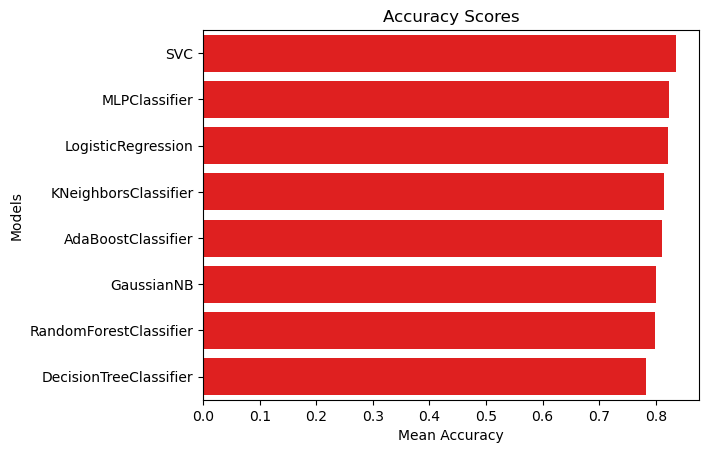

In [122]:
# function to evaluate models
def validate_estimators(models):
    results = {}
    for model in models:
        results[model.__class__.__name__] = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

    return results

# models to evaluate
models = [RandomForestClassifier(),
         SVC(),
         LogisticRegression(),
         KNeighborsClassifier(),
         DecisionTreeClassifier(),
         GaussianNB(),
         MLPClassifier(),
         AdaBoostClassifier()]

# get results
results = validate_estimators(models)
results = pd.Series(results).sort_values(ascending=False)

# plot results
plt.title('Accuracy Scores');
plt.ylabel('Models');
plt.xlabel('Mean Accuracy');
sns.barplot(results, orient='h', color='red');

The `SVC`, `MLPClassifier` and the `LogisticRegression` models were our top performers. Next, we'll optimize them.

# Optimize selection

In [165]:
svc_clf = SVC()
mlp_clf = MLPClassifier()
lr_clf = LogisticRegression()

# parameter grids
svc_grid = {
    'C': [0.1, 1, 10],            
    'kernel': ['linear', 'rbf'], 
    'gamma': [0.01, 0.1, 1]
}

mlp_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],  
    'activation': ['relu', 'tanh'], 
    'solver': ['adam', 'sgd'], 
    'alpha': [0.0001, 0.001, 0.01], 
    'learning_rate': ['constant', 'adaptive'],
}

lr_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'penalty': ['l1', 'l2'],
}

In [166]:
svc_search = GridSearchCV(svc_clf, svc_grid, scoring='accuracy', cv=5)
mlp_search = GridSearchCV(mlp_clf, mlp_grid, scoring='accuracy', cv=5)
lr_search = GridSearchCV(lr_clf, lr_grid, scoring='accuracy', cv=5)

svc_search.fit(X_train, y_train)
mlp_search.fit(X_train, y_train)
lr_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [168]:
svc_search.best_score_, mlp_search.best_score_, lr_search.best_score_

(0.8349946644906158, 0.8282844768062269, 0.8215554579122465)

# Test

<b>Obtain test data with selected features.
</b>

In [154]:
X_test = pd.get_dummies(test_df[features])

<b>Get predictions using our fitted model</b>

In [169]:
svc_opt = grid_search.best_estimator_
svc_opt.fit(X_train, y_train)
y_pred = svc_opt.predict(X_test)

In [170]:
accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy of the final model on the test data is: {accuracy:}")

The accuracy of the final model on the test data is: 0.7799043062200957
